# Titanic Survival Prediction: A Detailed Data Science Investigation (V2)

## Goal
Welcome. Our objective is to predict whether a passenger on the Titanic survived based on data such as their age, gender, and social status. This report is designed to be readable for everyone, explaining our findings and mathematical choices in plain English.

**Key Metrics:**
We use **AUC (Area Under the Curve)**. Think of this as a score from 0 to 1 where 1 is a perfect "guess" and 0.5 is no better than flipping a coin. 

## Workflow Outline:
1. **Investigation (EDA):** We look for patterns in the data.
2. **Engineering:** We clean and transform data for better accuracy.
3. **Modeling:** We train four different "Artificial Intelligence" models.
4. **Explanation:** We use "SHAP" to see exactly why the models made their choices.

In [10]:
# 1. Load all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

# Visualization settings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted")
%matplotlib inline
print("Tools loaded successfully.")

Tools loaded successfully.


### Loading the Dataset
We bring in the passenger manifest. Every row is a person, and every column is a piece of information about them.

In [11]:
# 2. Load the dataset
# Ensure Titanic-Dataset.csv is in the same folder as this notebook
df = pd.read_csv('Titanic-Dataset.csv')
print(f"Dataset loaded. Total passengers: {len(df)}")
df.head()

Dataset loaded. Total passengers: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Dataset Exploration (EDA)
We look for clues. Who was most likely to survive?

### Survival by Category
The charts above show the 'Survival Rate'. Note that females and 1st-class passengers had a much higher probability of living.

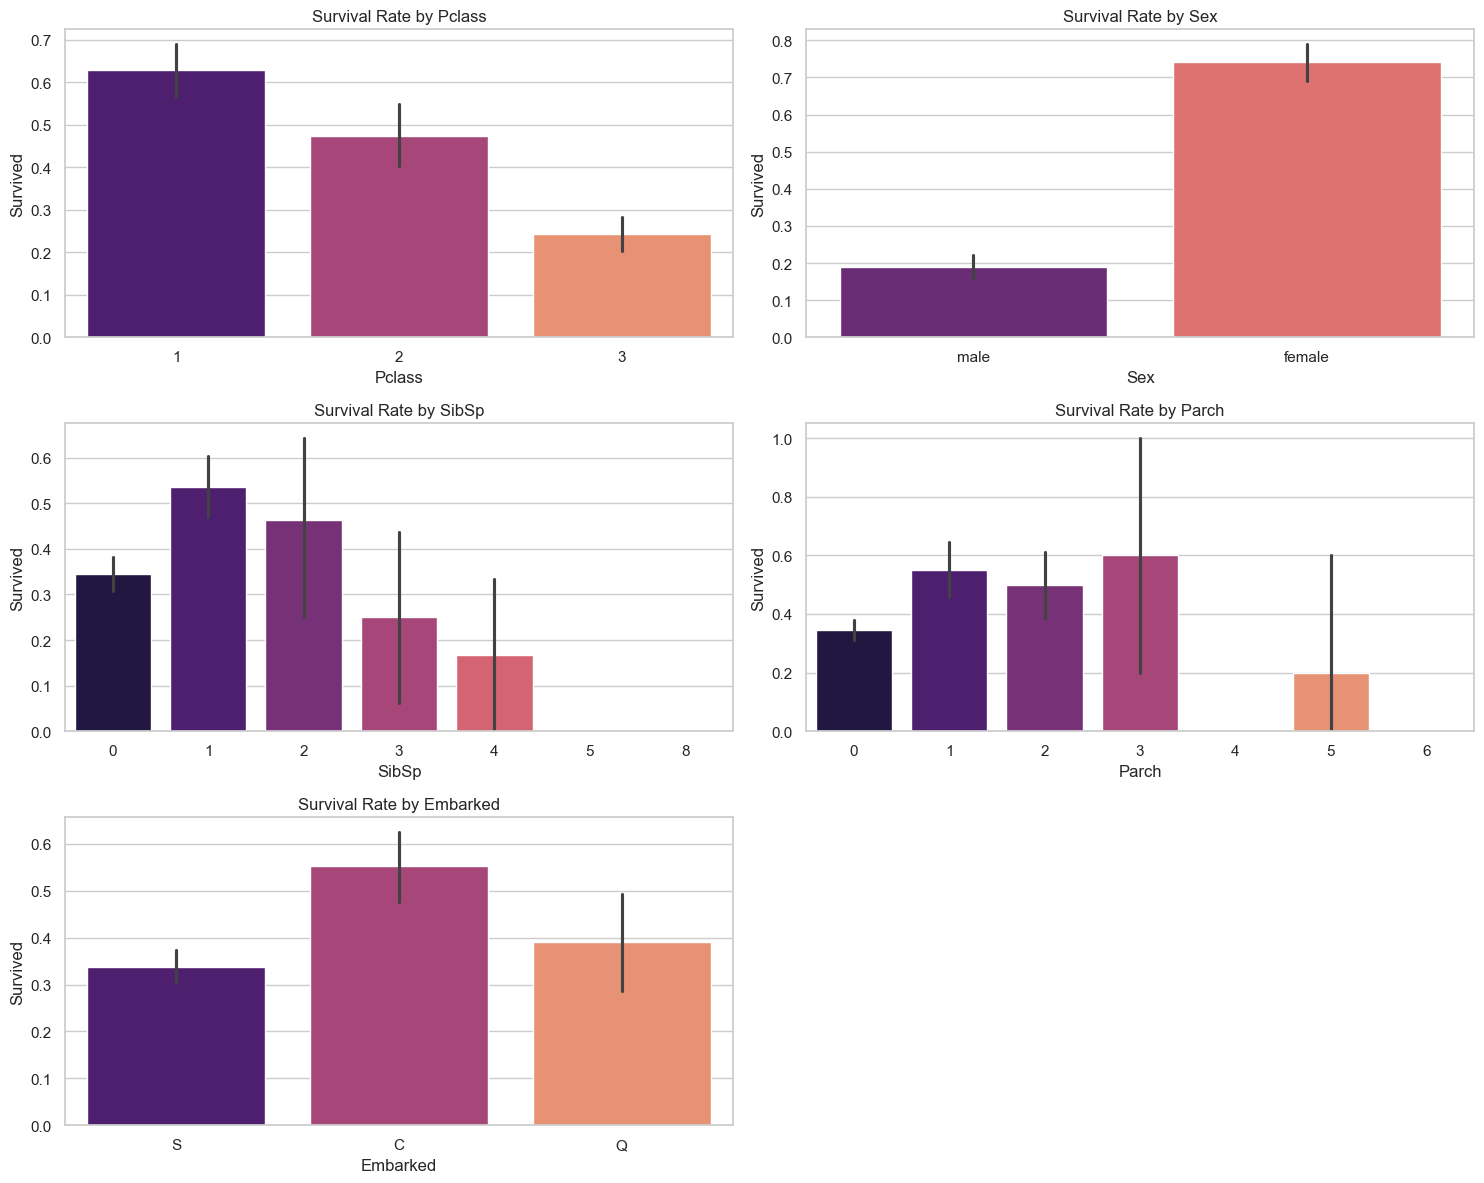

In [12]:
# 3a. Relationship between features and Survival
features_to_check = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

plt.figure(figsize=(15, 12))
for i, col in enumerate(features_to_check, 1):
    plt.subplot(3, 2, i)
    sns.barplot(data=df, x=col, y='Survived', palette='magma')
    plt.title(f'Survival Rate by {col}')

plt.tight_layout()
plt.show()

### Age and Wealth Interaction
There is a clear trend: older people tended to be in 1st class, and survivors generally paid higher fares.

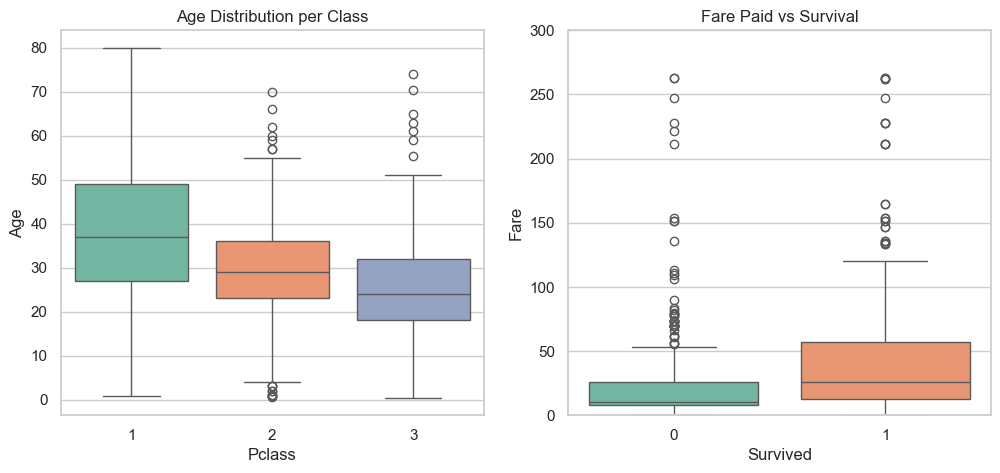

In [13]:
# 3b. Correlation between categorical and numerical values
# We look at Age vs Pclass and Fare vs Survived
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Pclass', y='Age', palette='Set2')
plt.title('Age Distribution per Class')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Survived', y='Fare', palette='Set2')
plt.title('Fare Paid vs Survival')
plt.ylim(0, 300) # Cutting off extreme outliers for better view
plt.show()

### The Mystery of Missing Data
Age is missing for about 20% of people. The chart shows that missing age data is more common in lower classes, which means the data is likely **Missing Not At Random (MNAR)**.

          Count  Percentage
Age         177   19.865320
Cabin       687   77.104377
Embarked      2    0.224467


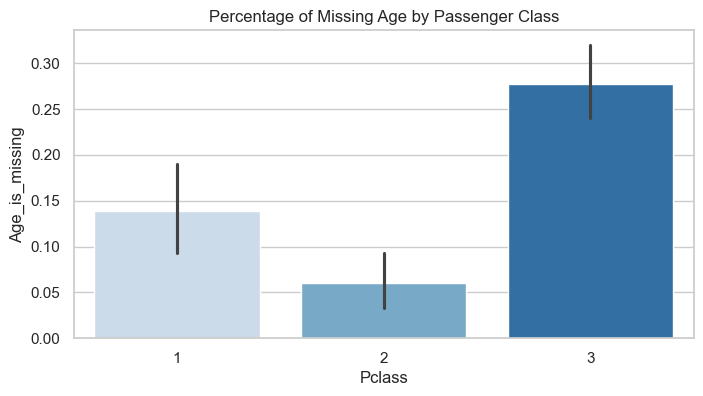

In [14]:
# 3c. Missing Value Analysis per feature
missing_data = df.isnull().sum().to_frame(name='Count')
missing_data['Percentage'] = (missing_data['Count'] / len(df)) * 100
print(missing_data[missing_data['Count'] > 0])

# Are missing values in 'Age' related to other features?
df['Age_is_missing'] = df['Age'].isnull().astype(int)
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='Pclass', y='Age_is_missing', palette='Blues')
plt.title('Percentage of Missing Age by Passenger Class')
plt.show()

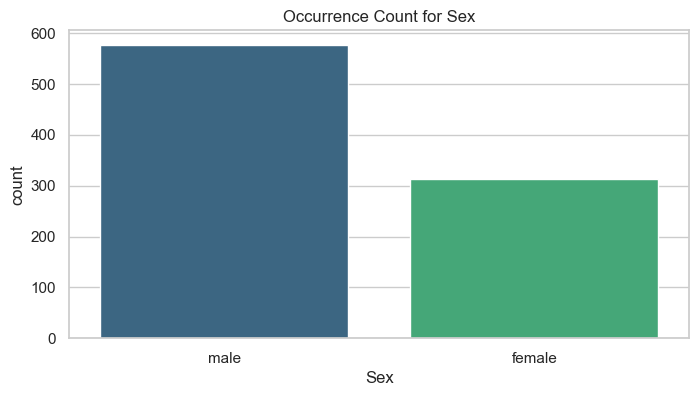

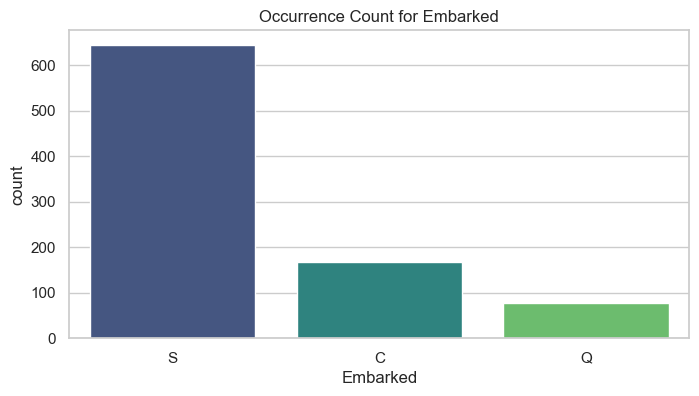

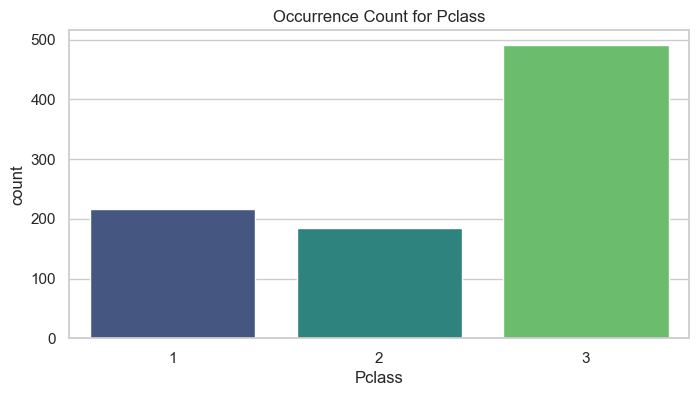

In [15]:
# 3d. Categorical value occurrence
for col in ['Sex', 'Embarked', 'Pclass']:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette='viridis')
    plt.title(f'Occurrence Count for {col}')
    plt.show()

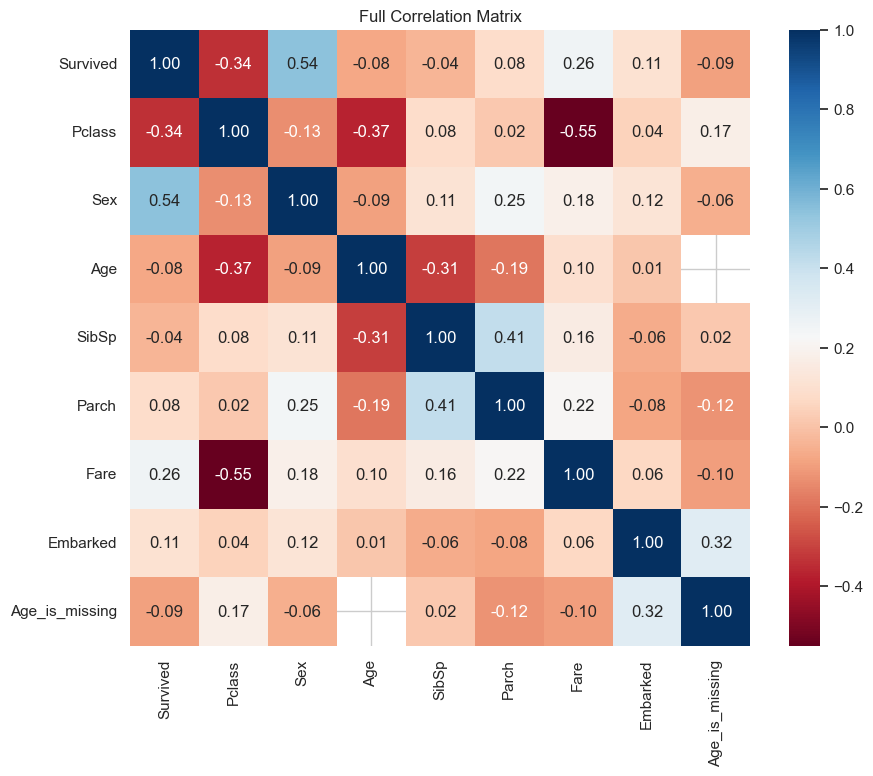

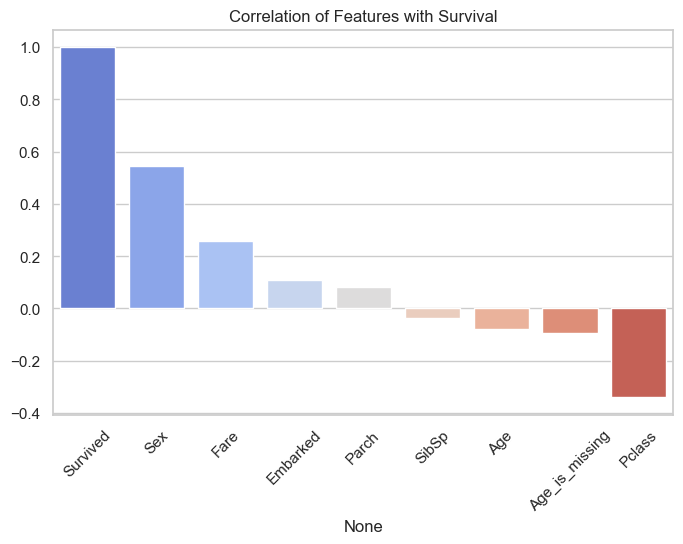

In [16]:
# 3e. Correlation Matrix to 'Survived'\n
# We map Sex to numbers for this analysis\n
df_num = df.copy()
df_num['Sex'] = df_num['Sex'].map({'male': 0, 'female': 1})
df_num['Embarked'] = df_num['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# We filter for numeric columns and exclude ID to prevent errors\n
df_numeric = df_num.select_dtypes(include=[np.number]).drop(columns=['PassengerId'], errors='ignore')
corr_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f')
plt.title('Full Correlation Matrix')
plt.show()

# Specific correlation to the target 'Survived' as requested
plt.figure(figsize=(8, 5))
target_corr = corr_matrix['Survived'].sort_values(ascending=False)
sns.barplot(x=target_corr.index, y=target_corr.values, palette='coolwarm')
plt.title('Correlation of Features with Survival')
plt.xticks(rotation=45)
plt.show()

### 3f. Feature Focus: Improving AUC
Features like 'Sex' and 'Pclass' are highly correlated with survival. To improve AUC, we will ensure our models capture the *interaction* between these (e.g., being a 3rd class male vs a 1st class male).

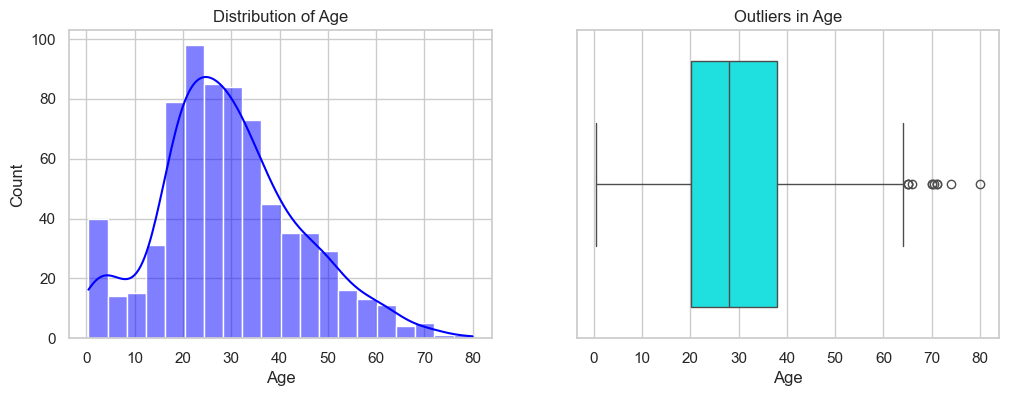

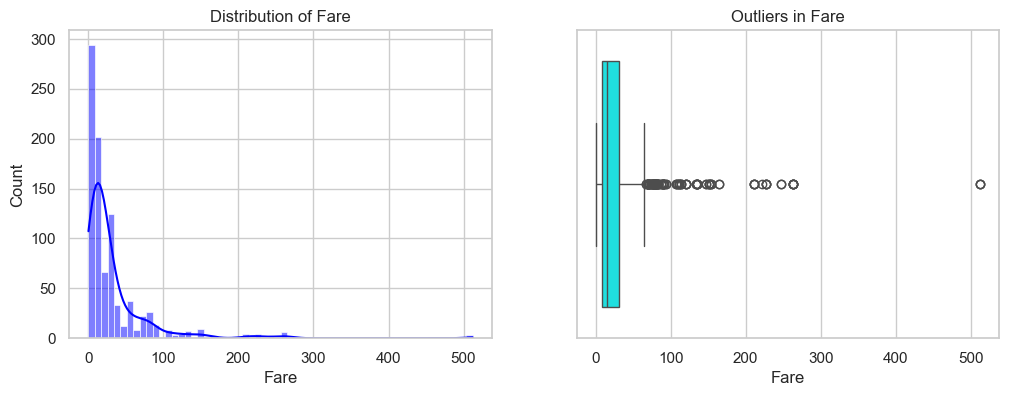

In [17]:
# 3g. Distribution for numeric features
for col in ['Age', 'Fare']:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True, color='blue')
    plt.title(f'Distribution of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col].dropna(), color='cyan')
    plt.title(f'Outliers in {col}')
    plt.show()

### EDA Findings Summary
1.  **Safety First:** 'Sex' is the strongest predictor. 'Women and children first' was a real mathematical trend.
2.  **Class Divide:** Wealthy passengers survived more often.
3.  **Missing Ages:** This isn't random. Lower class data is less complete.
4.  **Fare Outliers:** Some fares are extremely high; we should use 'Log transformation' to smooth these out for the math models.

## 4. Data Engineering
We create a 'FamilySize' feature and transform the 'Fare' into a 'LogScale'. This prevents very high ticket prices from confusing our mathematical models.

In [18]:
# 4. Data Engineering
# a. Transform to protect from outliers
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Fare_Log'] = np.log1p(df['Fare'])

# Define our X (features) and y (target)
X = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived', 'Fare', 'Age_is_missing'], axis=1)
y = df['Survived']

print("Features defined. We avoided imputation at this stage to prevent 'Data Leakage'.")

Features defined. We avoided imputation at this stage to prevent 'Data Leakage'.


## 5. Preprocessing
We split our data into three parts. **Training** to teach the computer, **Validation** to practice, and **Test** for the final exam.

In [19]:
# 5a. Splitting 60/20/20
# Split 1: 60% Train, 40% Temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Split 2: Divide Temp into 50% Test and 50% Val
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Test: {X_test.shape[0]}")

Training: 534 | Validation: 178 | Test: 179


In [20]:
# 5b, c, d. Imputation (MICE) & SMOTE Pipeline
num_cols = ['Age', 'SibSp', 'Parch', 'FamilySize', 'Fare_Log', 'IsAlone']
cat_cols = ['Pclass', 'Sex', 'Embarked']

# Advanced Imputation (MICE) only on Train
num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)), # MICE
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

def build_refined_pipeline(model):
    # Pipeline handles isolation: transforms are fit on Train, applied to Test
    return ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

In [21]:
# 6a. Hyperparameter Tuning
def tune_and_score(model, params, name):
    pipe = build_refined_pipeline(model)
    grid = GridSearchCV(pipe, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"{name} Best AUC: {grid.best_score_:.4f}")
    return grid.best_estimator_

# Tuning each model
lr_best = tune_and_score(LogisticRegression(max_iter=1000), {'classifier__C': [0.01, 0.1, 1, 10]}, "Logistic Regression")
rf_best = tune_and_score(RandomForestClassifier(random_state=42), {'classifier__n_estimators': [100, 300], 'classifier__max_depth': [5, 10]}, "Random Forest")
xgb_best = tune_and_score(XGBClassifier(eval_metric='logloss'), {'classifier__learning_rate': [0.01, 0.1], 'classifier__max_depth': [3, 6]}, "XGBoost")

# 6b. Dynamic Ensemble
ensemble = VotingClassifier(
    estimators=[('lr', lr_best), ('rf', rf_best), ('xgb', xgb_best)],
    voting='soft'
)
ensemble.fit(X_train, y_train)
print("Dynamic Ensemble complete.")

Logistic Regression Best AUC: 0.8539
Random Forest Best AUC: 0.8641
XGBoost Best AUC: 0.8583
Dynamic Ensemble complete.


## 6. Evaluation
We compare the 'brains' of our 4 models. The model with the highest AUC (Area Under the Curve) is the 'smartest' at distinguishing between survivors and non-survivors.

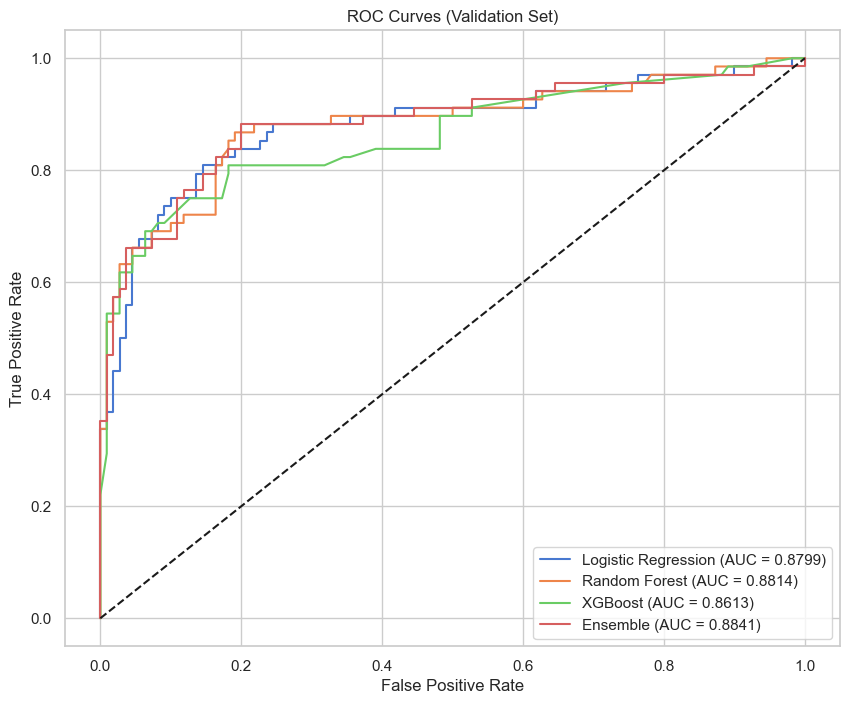

In [22]:
# 7. Model Evaluation (AUC & ROC)
models_dict = {'Logistic Regression': lr_best, 'Random Forest': rf_best, 'XGBoost': xgb_best, 'Ensemble': ensemble}

plt.figure(figsize=(10, 8))
for name, model in models_dict.items():
    y_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_prob)
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Validation Set)')
plt.legend()
plt.show()

## 7. Model Interpretability (SHAP)
We peek inside the 'black box' to see which features most influenced the predictions.


--- SHAP Summary for Logistic Regression ---
SHAP difficulty for Logistic Regression: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression(C=0.1, max_iter=1000)

--- SHAP Summary for Random Forest ---


<Figure size 640x480 with 0 Axes>

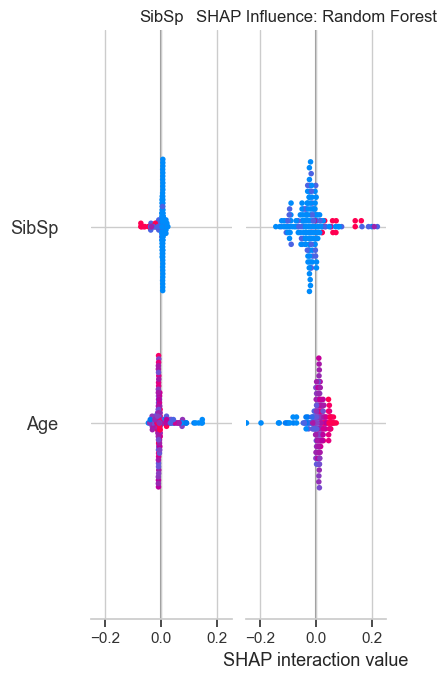


--- SHAP Summary for XGBoost ---


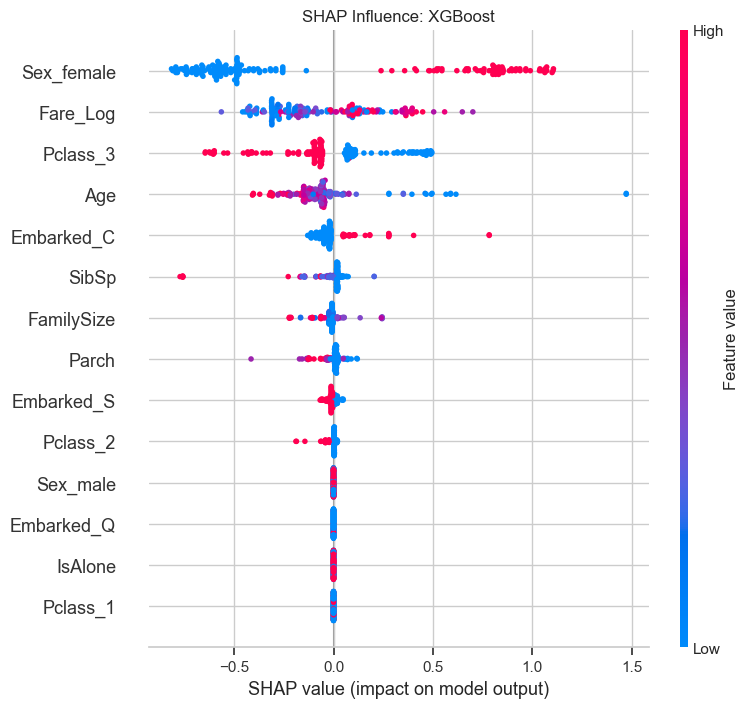


--- SHAP Summary for Ensemble ---


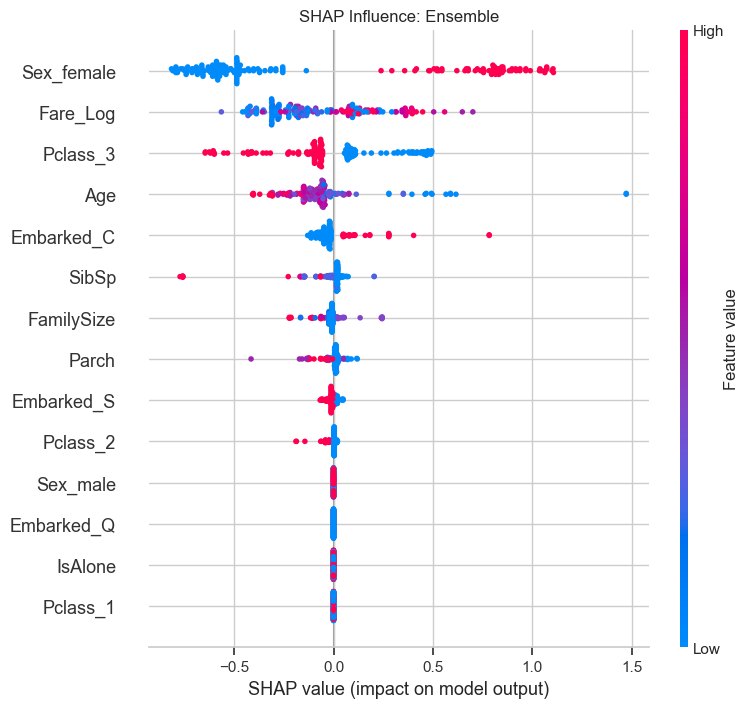

In [23]:
# 8. SHAP Interpretability for ALL models
# 1. Prep data for SHAP
transformer_fitted = lr_best.named_steps['preprocessor']
X_val_transformed = transformer_fitted.transform(X_val)
ohe_names = list(transformer_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols))
feature_names = num_cols + ohe_names

for name, model in models_dict.items():
    print(f"\n--- SHAP Summary for {name} ---")
    clf = model.named_steps['classifier'] if name != 'Ensemble' else ensemble.named_estimators_['xgb'].named_steps['classifier']
    
    try:
        if name in ['Random Forest', 'XGBoost', 'Ensemble']:
            explainer = shap.TreeExplainer(clf)
            shap_vals = explainer.shap_values(X_val_transformed)
            # Handling multi-output SHAP for RF
            if isinstance(shap_vals, list): shap_vals = shap_vals[1] 
        else:
            explainer = shap.Explainer(clf, feature_names=feature_names)
            shap_vals = explainer(X_val_transformed)
        
        plt.figure()
        shap.summary_plot(shap_vals, X_val_transformed, feature_names=feature_names, show=False)
        plt.title(f'SHAP Influence: {name}')
        plt.show()
    except Exception as e:
        print(f"SHAP difficulty for {name}: {e}")

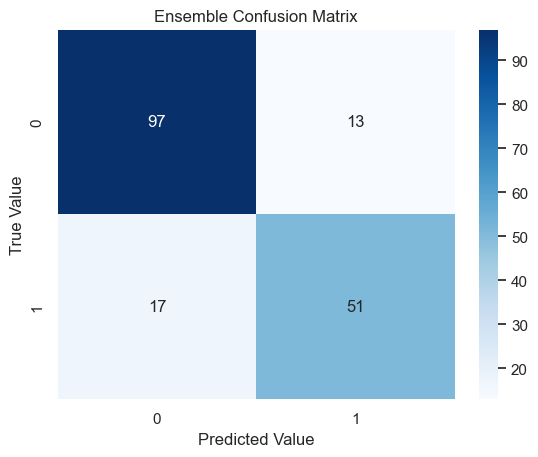


NEXT STEPS:
1. Feature Interaction: Explore connections like 'Young Children' in '3rd Class'.
2. Deck Mapping: Extract the cabin letter to see if certain decks were evacuated faster.
3. Advanced XGB Tuning: Further depth on gamma and min_child_weight.



In [24]:
# 9. False Positive Analysis & Next Steps
y_pred = ensemble.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Confusion Matrix')
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.show()

print("""
NEXT STEPS:
1. Feature Interaction: Explore connections like 'Young Children' in '3rd Class'.
2. Deck Mapping: Extract the cabin letter to see if certain decks were evacuated faster.
3. Advanced XGB Tuning: Further depth on gamma and min_child_weight.
""")